# Protein Folding Application: Two State Folding

The following notebook will demonstrate an application of a two state reversible kinetic model. We will use a Physics Informed Neural Network (PINN) to predict how much folded protein is present given some time $t$.

In [1]:
import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

## The Two State Model

The fundamental kinetic model encapsulating the protein folding process is the two-state kinetic model. The model defines the unfolded and folded state of a protein as $U$ and $N$ respectively. Primarily applicable to single domain proteins, this model assumes reversible folding and unfolding events unaided by external factors and that no stable intermediates are present in the (un)folding process.

$$\require{mhchem} \large{\ce{U <=>[\, k_f \,][\, k_u \,] N}}$$

There are two main kinetic values that drive this process, the rate of folding $k_f$ and rate of unfolding $k_u$. The equlibrium constant $K_{eq}$ is the ratio of these two rates.

$${K_{eq} = \frac{k_u}{k_f}}$$

$K_{eq}$ is a key value as it allows us to determine the stability of the single domain protein $\Delta G^{UN}$ given some temperature $T$ in Kelvin.

$${\Delta G^{UN} = -RT\ln(K_{eq})}$$

The differential function that represents the change of the folded population based on the kinetic model can be defined by the following equation.

$${\frac{d[N]}{dt} = k_f[U] - k_u[N]}$$

With the following mass balance law enforced where $[N]_0$ and $[U]_0$ is the initial population of folded and unfolded protein respectively. This is effectively the law of conservation (mass cannot be created nor destroyed).

$${[N]_0 + [U]_0 = [N] + [U]}$$ 

The mass balance law allows us to use substitution to make the ODE all in terms of $N$. Meaning we only need to track the change of a single population.

$${\frac{d[N]}{dt} = k_f([N]_0 + [U]_0 - [N]) - k_u[N]}$$

Tracking only the folded population is sufficient as the mass balance allows us to determine that the change in $U$ is the opposite of $N$.

$${\frac{d[N]}{dt} = -\frac{d[U]}{dt}}$$

## Solving for $[N]$

The following differential equation is a linear first-order ODE which has the following general solution given the mass balance above as our boundary condition ($[N](t = 0) = [N]_0$).

$${[N](t) = \frac{k_f([N]_0 + [U]_0)}{(k_f + k_u)} + \left([N]_0 - \frac{k_f([N]_0 + [U]_0)}{(k_f + k_u)}\right)e^{-(k_f + k_u)t}}$$ 

As $t \rightarrow \infty$, the function reaches the following limit which we define as $[N]_{eq}$. This is the expected folded population when equilibrium is reached.

$${[N](t \rightarrow \infty) = [N]_{eq} = \frac{k_f([N]_0 + [U]_0)}{(k_f + k_u)}}$$ 

We can finally substitute $[N]_{eq}$ to simplify the ODE solution we have above, the solution we have below will be used to generate data to train our neural networks with.

$${[N](t) = [N]_{eq} + \left([N]_0 - [N]_{eq}\right)e^{-(k_f + k_u)t}}$$ 


## Why apply a neural network to a known ODE?

The purpose is to test if we in fact can teach black box methods to predict properties that adhere to physical laws. The convenience of having a known solution to this ODE is powerful in that we can generate a dataset to train the model with and to test if NNs can in fact adhere to physical laws and constraints that we see in the real world.

## Generating Example Data Given ODE solution of $[N]$
We will first generate example data to which will be applied for our Neural Network models. The protein we will generate data for is the WW prototype protein ([PDB: 1E0M](https://www.rcsb.org/structure/1e0m)). The kinetic rates $k_f$ and $k_u$ for WW were determined experimentally in the [following publication](https://doi.org/10.1073/pnas.221467198). We will assume that at initial conditions ($t = 0$) all protein in solution is at the folded state.

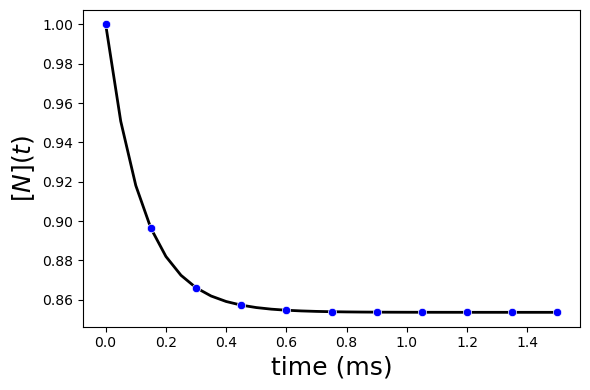

In [2]:
kfexp, kuexp = 7.0, 1.2  # in units per millisecond
N_0, U_0 = 1, 0


def gen_folding_population(
    t: np.ndarray, kf: float, ku: float, initial_N: float = 1, initial_U: float = 0) -> np.ndarray:
    """
    The function computes the folded population given times t, kinetic rates kf and ku, and initial
    population conditions.

    Parameters
    ----------
    t: np.ndarray
        Array of time domain.
    kf: float
        Experimental folding rate.
    ku: float
        Experimental unfolding rate.
    initial_N:
        Initial size of folded population.
    initial_U
        Initial size of unfolded population.

    Returns
    -------
    rtype: np.ndarray
        Returns an array of folded population at times t.
    """
    N_eq = (kf * (initial_N + initial_U)) / (kf + ku)
    return N_eq + ((initial_N - N_eq) * np.exp(-t * (kf + ku)))


# generate time domain and population N
t_domain = np.linspace(0, 1.5, 31)
N_domain = gen_folding_population(t_domain, kfexp, kuexp, N_0, U_0)

# plot data
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.lineplot(x=t_domain, y=N_domain, ax=ax, color='black', linewidth=2)
sns.scatterplot(x=t_domain[::3], y=N_domain[::3], ax=ax, color='blue', zorder=2)
ax.set_xlabel('time (ms)', fontsize = 18)
ax.set_ylabel('$[N](t)$', fontsize = 18)
plt.tight_layout()
plt.show()

## Naive Neural Network Application
The first application is to demonstrate the naive approach to predicting population $[N]$ over time $t$. The nerual network will be developed using PyTorch and the loss function we will employ is the classic mean squared error. Our loss function $\mathcal{L}$ is defined as $$ {\mathcal{L} = \min \frac{1}{n} \sum^{n}([N]_{\mathrm{D}}(t) - [N]_{\mathrm{M}}(t, \theta))^2} $$ where $[N]_{\mathrm{D}}(t)$ is the true population of $N$ at time $t$ and $[N]_{\mathrm{M}}(t)$ is the neural network's prediction of $N$ at time $t$ given parameters $\theta$.

The following code block contains the neural network class along with visualization functions and initializing the training data.

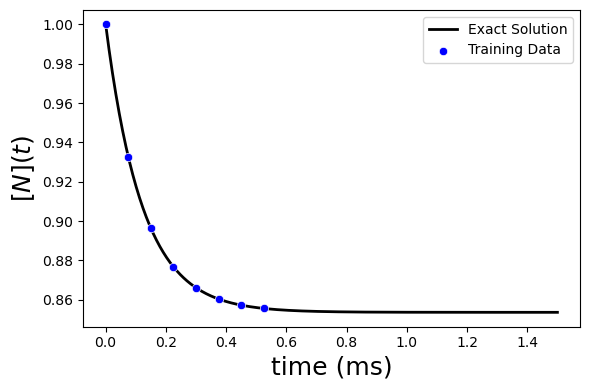

In [6]:
class FCNN(nn.Module):
    def __init__(self, in_size, out_size, hidden_size, n_layers):
        """
        Basic fully connected neural network (FCNN) class.

        Parameters
        ----------
        in_size: int
            Number of input parameters.
        out_size: int
            Size of output parameters.
        hidden_size: int
            Size of the hidden layers.
        n_layers: int
            Number of hidden layers desired in neural network.

        Returns
        -------
        rtype: FCNN
            An fully connected neural network.
        """
        super().__init__()
        self.fc_input = nn.Sequential(*[
            nn.Linear(in_size, hidden_size), nn.ReLU()
        ])
        self.fc_hidden = nn.Sequential(*[
            nn.Sequential(*[nn.Linear(hidden_size, hidden_size), nn.ReLU()]) 
            for _ in range(n_layers - 1)
        ])
        self.fc_output = nn.Linear(hidden_size, out_size)

    def forward(self, x) -> torch.Tensor:
        """
        Forward function.

        Parameters
        ----------
        x: torch.Tensor
            Input vector to feed.

        Returns
        -------
        rtype: torch.Tensor
            Output vector.
        """
        x = self.fc_input(x)
        x = self.fc_hidden(x)
        x = self.fc_output(x)
        return x


def visualize_nn_performance(train_x, train_y, pred_y, x_full,y_full, iter_) -> None:
    """
    Plots the performance of the neural network given some data and input domain.

    Parameters
    ----------
    train_x: torch.Tensor
        The training input data given to the neural network.
    train_y: torch.Tensor
        The training solution data given to the neural network.
    pred_y: torch.Tensor
        The predicted solution given by the neural network.
    x_full: torch.Tensor
        The full input data, includes the portion not selected.
    y_full: torch.Tensor
        The full output data, includes the portion not selected.
    iter_: int
        The current iteration of the neural network.

    Returns
    -------
    rtype: None
        Outputs the plot of the performance.
    """
    fig, ax = plt.subplots(1, 1, figsize=(7.5, 4))

    # visualize the prediction vs solution
    sns.lineplot(
        x=x_full.view(-1), y=y_full.view(-1), ax=ax, linestyle='dashed',
        color='black', linewidth=2, alpha=0.8, label="Exact Solution"
    )
    sns.lineplot(
        x=x_full.view(-1), y=pred_y.view(-1), ax=ax, 
        color='red', linewidth=4, alpha=0.8, label="NN Prediction"
    )

    # visualizes the datapoints given to train the network with
    sns.scatterplot(
        x=train_x.view(-1), y=train_y.view(-1), ax=ax, 
        color='blue', zorder=10, label="Training Data"
    )

    # extra add ins for legend and axis settings
    l = plt.legend(loc=(1.01, 0.34), frameon=False, fontsize='large')
    plt.setp(l.get_texts(), color='black')
    plt.xlim(-0.05, 1.55)
    plt.ylim(0.84, 1.02)
    plt.text(1.755, 0.895, f"Iteration {iter_ + 1}", fontsize='large', color='black')
    ax.set_xlabel('time (ms)', fontsize = 18)
    ax.set_ylabel('$[N](t)$', fontsize = 18)

    # visualize
    plt.tight_layout()
    plt.show()
    plt.close()


# make input and output data, view is essentially np.reshape
t = torch.linspace(0, 1.5, 401).view(-1, 1)
pop_N = gen_folding_population(t, kfexp, kuexp).view(-1, 1)

# take a subset of the data
train_x = t[0:150:20]
train_y = pop_N[0:150:20]


# plot data we will train with
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
sns.lineplot(
    x=t.view(-1), y=pop_N.view(-1), ax=ax, 
    color='black', linewidth=2, label="Exact Solution"
)
sns.scatterplot(
    x=train_x.view(-1), y=train_y.view(-1), ax=ax, 
    color='blue', label="Training Data", zorder=2
)
ax.set_xlabel('time (ms)', fontsize = 18)
ax.set_ylabel('$[N](t)$', fontsize = 18)
plt.tight_layout()
plt.show()

## Training the Naive Neural Network
We will train simple 3 layer neural network to predict $[N]$. The main problem one should notice is that the model fails to capture the true behavior of $[N]$ in times $t$ outside of the training data. This is expected as all the knowledge the neural network has access to is the training data.

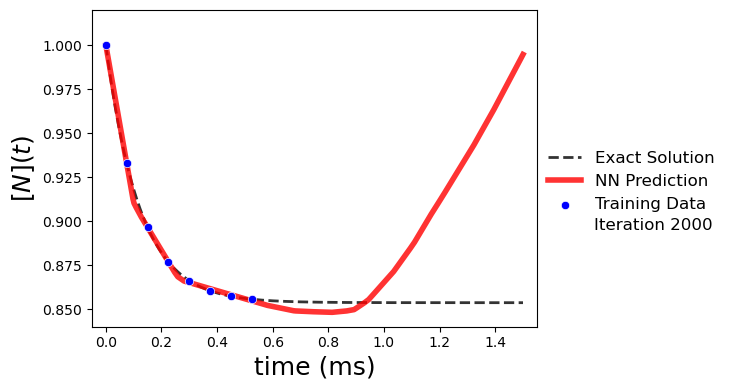

In [7]:
torch.manual_seed(217)
n_iterations = 2000
model = FCNN(1, 1, 64, 3)
optimizer = torch.optim.Adam(model.parameters(),lr=8e-3)

# training loop
for iter_ in range(n_iterations):
    optimizer.zero_grad()
    pred_y = model(train_x)
    loss = torch.mean((pred_y - train_y) ** 2) # MSE loss
    loss.backward()
    optimizer.step()

    # # plot results every 100 iterations
    # if (iter_ + 1) % 100 == 0:
    #     pred_y = model(t).detach()
    #     visualize_nn_performance(train_x, train_y, pred_y, t, pop_N, iter_)


# visualize final performance
pred_y = model(t).detach()
visualize_nn_performance(train_x, train_y, pred_y, t, pop_N, n_iterations - 1)


## Training a Physics Informed Neural Network
We will now apply physical information to our model. How?

Well... let us look back at the governing ODE that defines our kinetic model. The differential below is the governing function our data must behave in along the time domain $t$. $${\frac{d[N]}{dt} = k_f([N]_0 + [U]_0 - [N]) - k_u[N]}$$ The neural network can be "physically informed" by including the ODE to the loss function of the model. We can do this because we can set the ODE equal to zero using algebra. $${\frac{d[N]}{dt} - k_f([N]_0 + [U]_0 - [N]) + k_u[N] = 0}$$ because we are predicting for $[N]$, we can ensure that we are following the governing function of the kinetic model, assuming our initial conditions for $[N]_0$ and $[U]_0$ are known (along with the kinetic rates). This lets us produce a "physically informed" loss function defined below where $\require{color} {\color{blue}[N]_{\mathrm{M}}(t, \theta)}$ is the neural network's prediction of $[N]$. 

$$\require{color}  {\mathcal{L} = \min \left[\frac{1}{n} \sum^{n}([N]_{\mathrm{D}}(t) - {\color{blue}[N]_{\mathrm{M}}(t, \theta)})^2 + \frac{1}{m} \sum^{m}\left(\frac{d{\color{blue}[N]_{\mathrm{M}}(t, \theta)}}{dt} - k_f([N]_0 + [U]_0 - {\color{blue}[N]_{\mathrm{M}}(t, \theta)}) + k_u{\color{blue}[N]_{\mathrm{M}}(t, \theta)}\right)^2\right]}$$

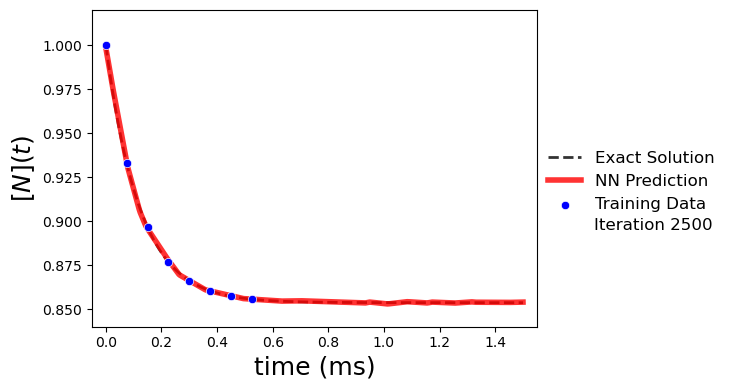

In [9]:
torch.manual_seed(217)
n_iterations = 2500
model = FCNN(1, 1, 64, 3)
optimizer = torch.optim.Adam(model.parameters(),lr=8e-3)
t_ode = t.detach().clone().requires_grad_(True)

# training loop
for iter_ in range(n_iterations):
    optimizer.zero_grad()
    pred_y = model(train_x)
    loss_mse = torch.mean((pred_y - train_y) ** 2) # MSE loss
    dNdt = torch.autograd.grad(model(t_ode), t_ode, torch.ones_like(model(t)), create_graph=True)[0] # dN/dt
    loss_ode = torch.mean((dNdt - (kfexp * (N_0 + U_0 - model(t_ode))) + (kuexp * model(t_ode))) ** 2) # ODE loss
    loss = loss_mse + (1e-2 * loss_ode)
    loss.backward()
    optimizer.step()

    # # plot results every 100 iterations
    # if (iter_ + 1) % 100 == 0:
    #     pred_y = model(t).detach()
    #     visualize_nn_performance(train_x, train_y, pred_y, t, pop_N, iter_)


# visualize final performance
pred_y = model(t).detach()
visualize_nn_performance(train_x, train_y, pred_y, t, pop_N, n_iterations - 1)


## Key Significance of Adding the Governing ODE
The first thing that should be mentioned is that when we applied `torch.autograd.grad` (derivative along $t$) notice that no extra data points were given to the neural network, we only added an extra constraint that the predictions of the neural network must behave in. This is significant because we did not need to all the data points of $[N]$, the blue data points where sufficient to make the neural network predict along the entire domian of $t$ accurately.

### Summary
Using the fundamental kinetic model that defines protein folding, we developed neural network that is "physically informed" and able to predict the folding population of the WW protein given some time $t$. We achived this by training a neural network with a small sample of points which achieved a solution using only the mean squared error of the sample data along with the governing differential of the kinetic model as a loss function.
